# Dynamic PET kinetic modeling example

Samuel Kuttner. 2024-09-24

samuel.kuttner@uit.no

## Background
Tissue compartment modeling is used to perform quantification in PET imaging. It requires at least one tissue curve and and an arterial input function (AIF).

## Aim
The purpose of this exercise is to learn how to perform tissue compartment modeling in Python using the reversible two tissue compartment model.

## Requirments
* You can work either using your local standard Python installation, or by using for example Google Colabs.

* Dataset

    The data for this exercise is available in this repository under ".../Example_data/".
  
    The data consists of two files:
    - The AIF of a mouse measured during 45 minutes with 1s sampling interval.
    - Tissue curves from four tissue regions: Brain, left ventricle, Liver and Myocardium.


Import necessary libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os

* If running local Jupiyther notebook, specify local data path as WDIR.

* If running on Colabs, specify the data path in your Google Drive folder
(as "/content/drive/My Drive/...")

In [2]:
if "Users" in os.getcwd():
  #Local runtime
  print("Local runtime")
  WDIR = "/Users/sku014/Library/CloudStorage/OneDrive-UiTOffice365/Research/Presentationer_Undervisning/Kurser/Physics in Nuclear Medicine Special Curriculum/Python demo/dPET_dcm_M3/"

elif "content" in os.getcwd():
  #Assume Colabs runtime
  #From: https://realpython.com/generative-adversarial-networks/
  #Mount google drive and set working directory (wdir)
  print("Colabs runtime")
  from google.colab import drive
  drive.mount('/content/drive/')
  WDIR = "/content/drive/My Drive/Jobb/PET_ML_Research/Kurs & Konferens/Physics in Nuclear Medicine Special Curriculum/"

else:
  # Data from Example_data folder
  print("Local runtime")
  WDIR = "./Example_data/"

PATH_AIF = WDIR + "AIF_shift_SUV_M3.txt"
PATH_VOI = WDIR + "VOIdata_M3.voistat"

Local runtime


Read the AIF data.

- `AIF_A` is the arterial input function in SUV, delay corrected (shifted) to match the PET data
- `AIF_t` is the time vector in minutes


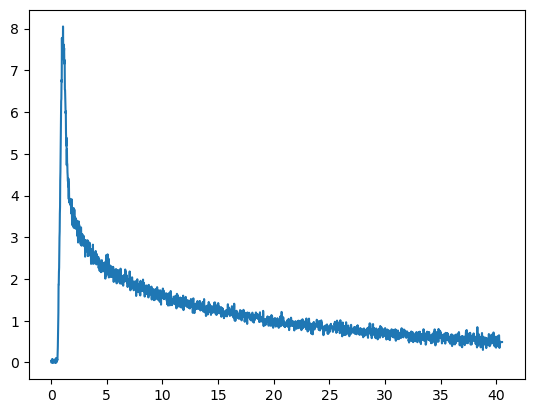

In [3]:
with open(PATH_AIF, "rb") as f:
    df = pd.read_csv(f, sep="\t")

COLS = df.columns

AIF_t = np.array(df.loc[:, [COLS[0]]]).squeeze()
AIF_t = (AIF_t - AIF_t[0])  # Zero shift
AIF_A = np.array(df.loc[:, [COLS[1]]]).squeeze()

plt.plot(AIF_t, AIF_A)

Read the VOI data. Exclude the 7 line header in the *.voistat file

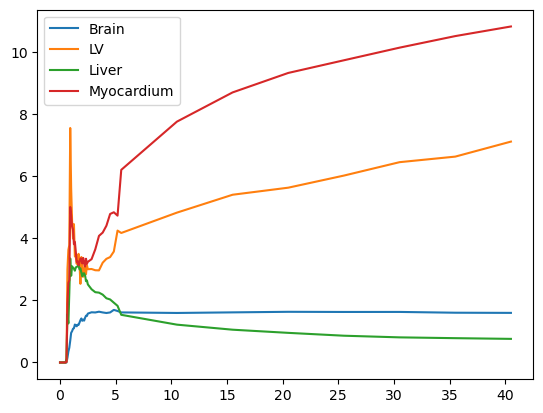

In [4]:
with open(PATH_VOI, "rb") as f:
    df = pd.read_csv(f, sep="\t", header=7)

COLS = df.columns


#VOI names
VOI_names = np.array(df.loc[:, [COLS[9]]]).squeeze()
VOI_names_unique, VOI_start_idx = np.unique(VOI_names, return_index=True)

#Number of time frames
num_frames = int(len(VOI_names) / len(VOI_names_unique))

# Add VOI data to dictionary
VOI_A_dict = {}

for idx, start_idx in enumerate(VOI_start_idx):
    start = start_idx
    end = start_idx + num_frames - 1
    VOI_A = np.array(df.loc[start:end, [COLS[11]]]).squeeze()
    VOI_A_dict.update({VOI_names_unique[idx]:VOI_A})

#Extract time from last VOI index (all times are equal by definition from PMOD!
VOI_t = np.array(df.loc[start:end, [COLS[10]]]).squeeze()

#Convert to frame start times (zero shift)
VOI_t_shift = np.zeros_like(VOI_t)
for idx, time in enumerate(VOI_t):
    if idx == 0:
        VOI_t_shift[idx] = 0
    else:
        VOI_t_shift[idx] = 2*VOI_t[idx-1] - VOI_t_shift[idx-1]

# Convert to minutes
VOI_t_shift = VOI_t_shift/60

#Plot VOI data
plt.plot(VOI_t_shift, VOI_A_dict[VOI_names_unique[0]], label=VOI_names_unique[0])
plt.plot(VOI_t_shift, VOI_A_dict[VOI_names_unique[1]], label=VOI_names_unique[1])
plt.plot(VOI_t_shift, VOI_A_dict[VOI_names_unique[2]], label=VOI_names_unique[2])
plt.plot(VOI_t_shift, VOI_A_dict[VOI_names_unique[3]], label=VOI_names_unique[3])
plt.legend()
plt.show()

Now it is time to define the functions for tissue compartment modeling (TCM). We will evaluate three different models, Reversible and irreversible two-tissue compartment model, and the Patlak model.

Thus, we need three functions:
1. An interpolation function that interpolates the AIF and VOI data to the same and constant time sampling, as well as shortens the longest to obtain equal length.

2. A function where the equations for the different models are defined.

3. An optimization function, using the `curve_fit` from the SciPy package.

In [5]:
from Tissue_compartment_modeling import (
    interpolate_time_frames,
    patlak,
    twoTCMirrev,
    twoTCMrev,
    oneTCM
)

Perform TCM of all tissues in the `*.voistat`-file.

In [6]:

# TCM_dict will store all the resuts from kinetic modeling (k-values)
oneTCM_dict = {}
twoTCMrev_dict = {}
twoTCMirrev_dict = {}
patlak_dict = {}

# Loop over the  tissues
for tissue in VOI_names_unique:
    print(tissue)

    # oneTCM
    (K1, k2, vB), tissue_fit, mse = oneTCM(
        AIF_A, AIF_t, VOI_A_dict[tissue], VOI_t_shift, INTERPOLATE=True, TIME_FRAMES=2.5
    )

    # Save everything into dictionary
    oneTCM_dict[tissue] = {
        "K1": K1,
        "k2": k2,
        "vB": vB,
        "tissue_fit": tissue_fit,
        "mse": mse
    }
    
    # Reversible 2TCM
    (K1, k2, vB, k3, k4), Ki, tissue_fit, mse = twoTCMrev(
        AIF_A, AIF_t, VOI_A_dict[tissue], VOI_t_shift, INTERPOLATE=True, TIME_FRAMES=2.5
    )

    # Save everything into dictionary
    twoTCMrev_dict[tissue] = {
        "K1": K1,
        "k2": k2,
        "k3": k3,
        "k4": k4,
        "vB": vB,
        "Ki": Ki,
        "tissue_fit": tissue_fit,
        "mse": mse
    }

    # Irreversible 2TCM
    (K1, k2, vB, k3), Ki, tissue_fit, mse = twoTCMirrev(
        AIF_A, AIF_t, VOI_A_dict[tissue], VOI_t_shift, INTERPOLATE=True, TIME_FRAMES=2.5
    )

    # Save everything into dictionary
    twoTCMirrev_dict[tissue] = {
        "K1": K1,
        "k2": k2,
        "k3": k3,
        "vB": vB,
        "Ki": Ki,
        "tissue_fit": tissue_fit,
        "mse": mse
    }

    # Patlak
    Ki, V0 = patlak(
        AIF_A, AIF_t, VOI_A_dict[tissue], VOI_t_shift, INTERPOLATE=True, TIME_FRAMES=2.5/60
    )

    # Save everything into dictionary
    patlak_dict[tissue] = {
        "Ki": Ki,
        "V0": V0,
    }

Brain
LV
Liver
Myocardium


Print the results

Plot the resulting tissue curves

In [7]:
print(oneTCM_dict)
print(twoTCMirrev_dict)
print(twoTCMrev_dict)
print(patlak_dict)

#Print Ki values rounded to 3 decimals
for tissue in VOI_names_unique:
    print(tissue)
    print("Patlak Ki: ", round(patlak_dict[tissue]["Ki"], 3))
    print("2TCMrev Ki: ", round(twoTCMrev_dict[tissue]["Ki"], 3))
    print("2TCMirrev Ki: ", round(twoTCMirrev_dict[tissue]["Ki"], 3))

{'Brain': {'K1': 4.46000738728107, 'k2': 0.9814997568594754, 'vB': 0.4253727889092648, 'tissue_fit': array([0.0215562 , 0.62939122, 1.23722623, ..., 1.57004733, 1.57004733,
       1.57004733]), 'mse': 0.18427883690555744}, 'LV': {'K1': 4.647859285850268e-14, 'k2': 9.999999999999957, 'vB': 3.10015976901471, 'tissue_fit': array([0.12359457, 3.59933002, 7.07506547, ..., 1.52039423, 1.52039423,
       1.52039423]), 'mse': 14.777310943942274}, 'Liver': {'K1': 1.658193077986968, 'k2': 9.227049297826922e-16, 'vB': 0.7120487435281839, 'tissue_fit': array([0.02924397, 0.8519624 , 1.67468083, ..., 0.72659688, 0.72659688,
       0.72659688]), 'mse': 0.2904375337700586}, 'Myocardium': {'K1': 2.120680233645145e-12, 'k2': 9.999999999998211, 'vB': 4.711254766357084, 'tissue_fit': array([ 0.18782436,  5.46983445, 10.75184455, ...,  2.31051465,
        2.31051465,  2.31051465]), 'mse': 24.24193403894775}}
{'Brain': {'K1': 0.1052383684658688, 'k2': 0.11415941800535714, 'k3': 0.07213083910900567, 'vB': 0

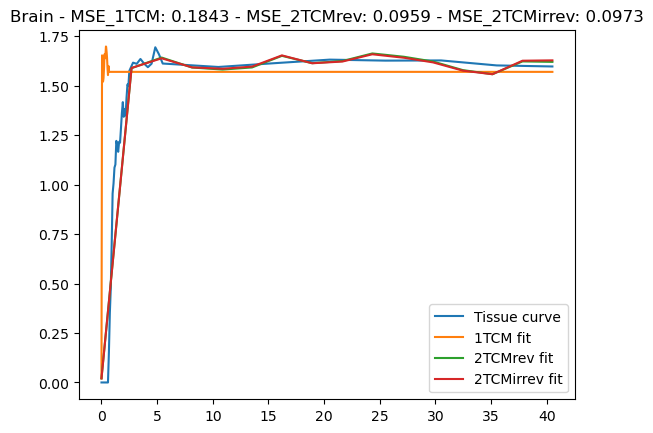

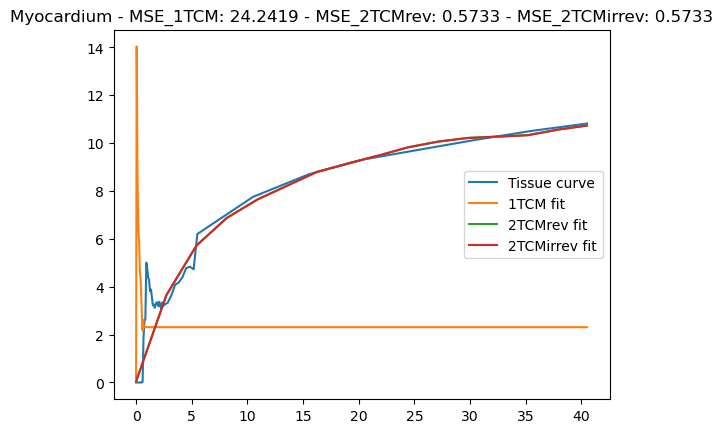

In [8]:
#Plot tissue curve and fit
tissue = "Brain"
plt.plot(VOI_t_shift, VOI_A_dict[tissue], label="Tissue curve")
plt.plot(AIF_t, oneTCM_dict[tissue]["tissue_fit"], label="1TCM fit")
plt.plot(AIF_t, twoTCMrev_dict[tissue]["tissue_fit"], label="2TCMrev fit")
plt.plot(AIF_t, twoTCMirrev_dict[tissue]["tissue_fit"], label="2TCMirrev fit")  
plt.title(tissue + " - MSE_1TCM: " + str(round(oneTCM_dict[tissue]["mse"],4)) + " - MSE_2TCMrev: " + str(round(twoTCMrev_dict[tissue]["mse"],4)) + " - MSE_2TCMirrev: " + str(round(twoTCMirrev_dict[tissue]["mse"],4)))
plt.legend()
plt.show()

tissue = "Myocardium"
plt.plot(VOI_t_shift, VOI_A_dict[tissue], label="Tissue curve")
plt.plot(AIF_t, oneTCM_dict[tissue]["tissue_fit"], label="1TCM fit")
plt.plot(AIF_t, twoTCMrev_dict[tissue]["tissue_fit"], label="2TCMrev fit")
plt.plot(AIF_t, twoTCMirrev_dict[tissue]["tissue_fit"], label="2TCMirrev fit")
plt.title(tissue + " - MSE_1TCM: " + str(round(oneTCM_dict[tissue]["mse"],4)) + " - MSE_2TCMrev: " + str(round(twoTCMrev_dict[tissue]["mse"],4)) + " - MSE_2TCMirrev: " + str(round(twoTCMirrev_dict[tissue]["mse"],4)))
plt.legend()
plt.show()


## Evaluation:

For this example data, it is evident that a one-tissue compartment model does not describe the data well (bad fit, large error). Rather, the model with the lowest error (MSE) should be choosen to fit the current data. In this case, for a two-tissue compartment model fits the data better. For the FDG tracer, k<sub>4</sub> is small for most tissues, so an irreversible model (2TCMirrev) describes the data well. 